# $$\text{WEATHER - BOSTON}$$
### $$\textbf{Analiza danych rzeczywistych przy pomocy modelu ARMA}$$

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import scipy.stats
from scipy.stats import ttest_1samp, levene, shapiro, jarque_bera, norm, fligner, kstest, cramervonmises
from scipy.optimize import curve_fit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acovf, acf, pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
import statsmodels.api as sm

## 1. Wstęp

    1.1. Czy w analizowanych danych występują braki?

In [101]:
# BOSTON
data = pd.read_csv('boston.csv')
data['time'] = pd.to_datetime(data['time'])
data.isnull().sum()

time      0
tavg      1
tmin      0
tmax      0
prcp      0
wdir    587
wspd      0
pres    161
dtype: int64

- uzupełnienie braków - średnia temperatura z dnia poprzedniego i dnia następnego

In [102]:
data['tavg'] = data['tavg'].replace('', np.nan)
missing_index = data[data['tavg'].isnull()].index[0]

data.head(missing_index+1)

,time,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2013-03-01,3.2,1.1,5.0,0.0,342.0,15.1,1002.7
1,2013-03-02,3.1,1.1,5.6,0.0,307.0,14.4,1004.2
2,2013-03-03,2.6,0.6,6.1,0.0,NaN,14.4,1002.6
3,2013-03-04,1.8,-0.6,5.0,0.0,303.0,28.1,1003.0
4,2013-03-05,2.9,0.0,6.1,0.0,NaN,16.6,1013.5
5,2013-03-06,3.2,1.7,5.0,1.3,58.0,36.7,1018.5
6,2013-03-07,0.4,-1.1,2.8,11.7,20.0,38.2,1016.5
7,2013-03-08,0.4,-2.2,5.6,23.9,9.0,29.5,1016.3
8,2013-03-09,1.8,-0.6,3.3,0.0,35.0,17.6,1024.3
9,2013-03-10,NaN,-2.2,2.8,0.0,NaN,12.6,NaN


In [103]:
prev_day = data['tavg'].iloc[missing_index - 1]
next_day = data['tavg'].iloc[missing_index + 1]
data.at[missing_index, 'tavg'] = (prev_day + next_day) / 2

data.head(missing_index+1)

,time,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2013-03-01,3.2,1.1,5.0,0.0,342.0,15.1,1002.7
1,2013-03-02,3.1,1.1,5.6,0.0,307.0,14.4,1004.2
2,2013-03-03,2.6,0.6,6.1,0.0,NaN,14.4,1002.6
3,2013-03-04,1.8,-0.6,5.0,0.0,303.0,28.1,1003.0
4,2013-03-05,2.9,0.0,6.1,0.0,NaN,16.6,1013.5
5,2013-03-06,3.2,1.7,5.0,1.3,58.0,36.7,1018.5
6,2013-03-07,0.4,-1.1,2.8,11.7,20.0,38.2,1016.5
7,2013-03-08,0.4,-2.2,5.6,23.9,9.0,29.5,1016.3
8,2013-03-09,1.8,-0.6,3.3,0.0,35.0,17.6,1024.3
9,2013-03-10,3.3,-2.2,2.8,0.0,NaN,12.6,NaN


    1.2. Czy badany zbiór danych zawiera informacje ze wszystkich dni z zakresu od 2013-03-01 do 2023-03-01 (tzn. 'równe oddalenie w czasie')?

In [104]:
data_copy = data.copy()
data_copy['time'] = pd.to_datetime(data_copy['time'])
data_copy.set_index('time', inplace=True)
data_copy.sort_index(inplace=True)

In [105]:
full_date_range = pd.date_range(start=data_copy.index.min(), end=data_copy.index.max(), freq='D')
missing_dates = full_date_range.difference(data_copy.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Odpowiedź brzmi tak.

    1.3. Wizualizacja danych

In [106]:
temp = data['tavg']
time = data['time']

Niech nasze dane 'temp' są reprezentacją szeregu $X_t$

In [107]:
Xt = temp.values

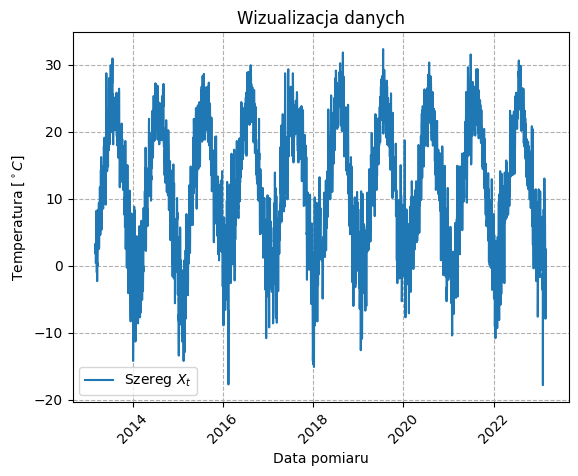

In [108]:
plt.plot(time, Xt, label = 'Szereg $X_t$')
plt.grid(True, linestyle = '--')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xlabel('Data pomiaru')
plt.xticks(rotation = 45)
plt.legend()
plt.title("Wizualizacja danych")
plt.savefig('Temperature_data.png', bbox_inches='tight')
plt.show()

## 2. Przygotowanie danych do analizy

    2.1. Jakość danych

- zakres badanych wartości

In [109]:
# minimalna i maksymalna temperatura
min_temp = np.min(Xt)
max_temp = np.max(Xt)

print('Minimalna wartość temperatury w danych:', min_temp)
print('Maksymalna wartość temperatury w danych:', max_temp)

Minimalna wartość temperatury w danych: -17.8
Maksymalna wartość temperatury w danych: 32.3


- Czy są wartości odstające?

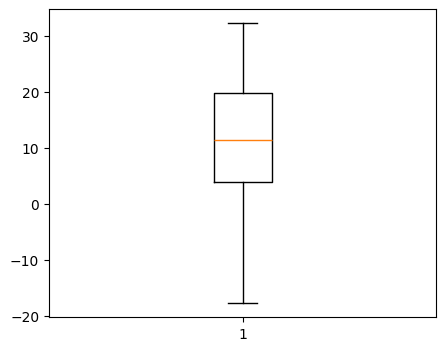

In [110]:
plt.figure(figsize=(5,4))
plt.boxplot(Xt)
plt.show()

    2.2. Dekompozycja szeregu czasowego

-  wykres ACF oraz PACF dla surowych danych - EMPIRYCZNIE

In [111]:
def autokowariancja_emp(x, h):
    n = len(x)
    autocov = np.zeros(len(h))
    for j, hi in enumerate(h):
        if hi < n:
            autocov[j] = (1 / n) * np.sum((x[:n - hi] - np.mean(x)) * (x[hi:] - np.mean(x)))
        else:
            autocov[j] = 0
    return autocov

In [112]:
def autokorelacja_emp(x, h):
    autocov = autokowariancja_emp(x, h)
    autocov_0 = autocov[0] 
    autokor = autocov / autocov_0
    return autokor

In [113]:
def partialautocor(x, h):
    gamma_hat = autokowariancja_emp(x, h)
    pacf = np.zeros(len(h))
    pacf[0] = 1.0 
    for k in range(1, len(h)):
        gamma_matrix = np.array([[gamma_hat[abs(i - j)] for j in range(k)] for i in range(k)])
        gamma_vector = gamma_hat[1 : k + 1]
        phi_k = np.linalg.solve(gamma_matrix, gamma_vector)
        pacf[k] = phi_k[-1]
    return pacf

- W dalszej części analizujemy wszystko dla lags = 40 !!

In [114]:
h = 40
h_range = np.arange(h+1)

In [115]:
ACF_emp = autokorelacja_emp(x = Xt, h = h_range)
PACF_emp = partialautocor(x = Xt, h = h_range)

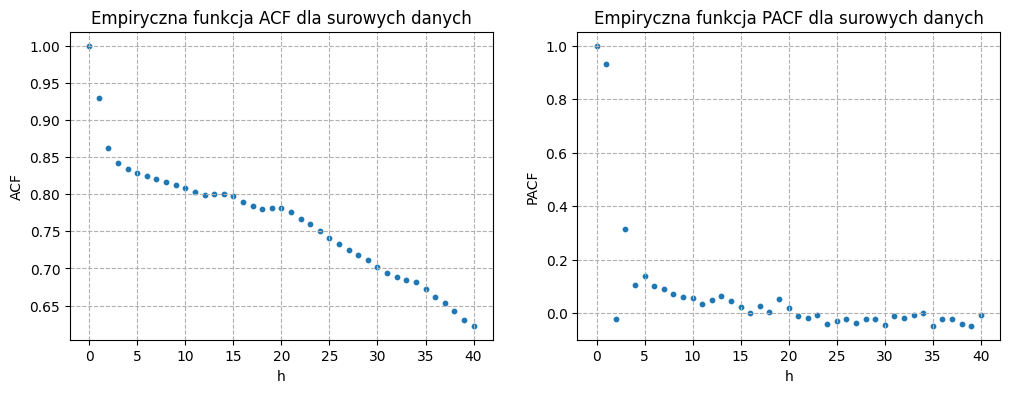

In [116]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(h_range, ACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja ACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('ACF')

plt.subplot(1,2,2)
plt.scatter(h_range, PACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja PACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('PACF')


plt.show()

-  wykres ACF oraz PACF dla surowych danych - WBUDOWANA FUNKCJA (statsmodels)

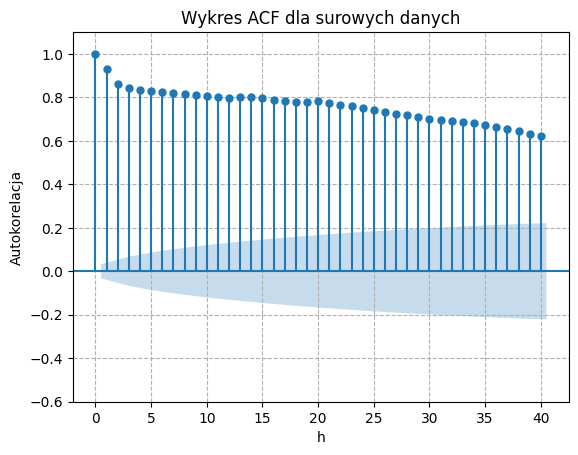

In [117]:
plot_acf(Xt, lags=h)
plt.title("Wykres ACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.ylim(-0.6,1.1)

plt.savefig('ACF_raw_data.png', bbox_inches='tight')
plt.show()

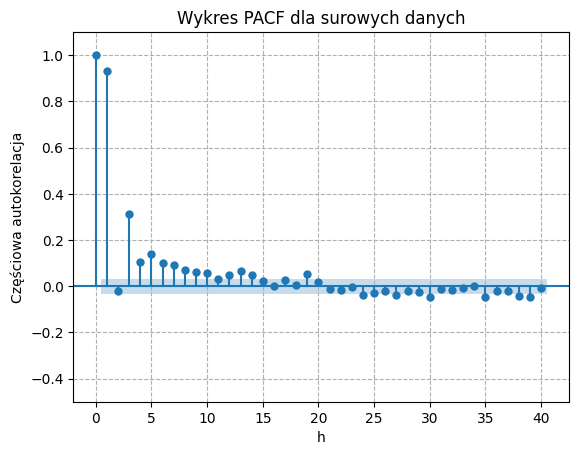

In [118]:
plot_pacf(Xt, lags=h, method='ywm')
plt.title("Wykres PACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_raw_data.png', bbox_inches='tight')
plt.show()


    2.3. (*opcjonalne) Testowanie stacjonarności - surowe dane

In [119]:
# Testowanie stacjonarności
def adfuller_test(series, sig=0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [120]:
is_Xt_stationary = adfuller_test(Xt)
is_Xt_stationary

Statystyka testowa = -3.601, p-Value = 0.006 => Stationary. 


    2.4. Identyfikacja trendów deterministycznych

$$ X_t = m(t) + s(t) + Y(t)  $$

- trend m(t)

In [121]:
xs_n = len(Xt)
t = np.linspace(0, xs_n, xs_n)
m_fit = np.polyfit(t, Xt, 1)
mt = np.polyval(m_fit, t)

In [122]:
Xt_without_trend = Xt - mt

- sezonowość s(t)

In [123]:
def s_func_para(t, a, b, c):
    return a*np.sin(b*t + c)

In [124]:
a_initial = (np.max(Xt) - np.min(Xt)) / 2
b_initial = 2 * np.pi / 365
c_initial = np.pi/2
d_initial = np.mean(Xt)

func_params, _ = curve_fit(s_func_para, t, Xt_without_trend, p0=[a_initial, b_initial, c_initial])

a_fit, b_fit, c_fit = func_params
st = s_func_para(t, a_fit, b_fit, c_fit)

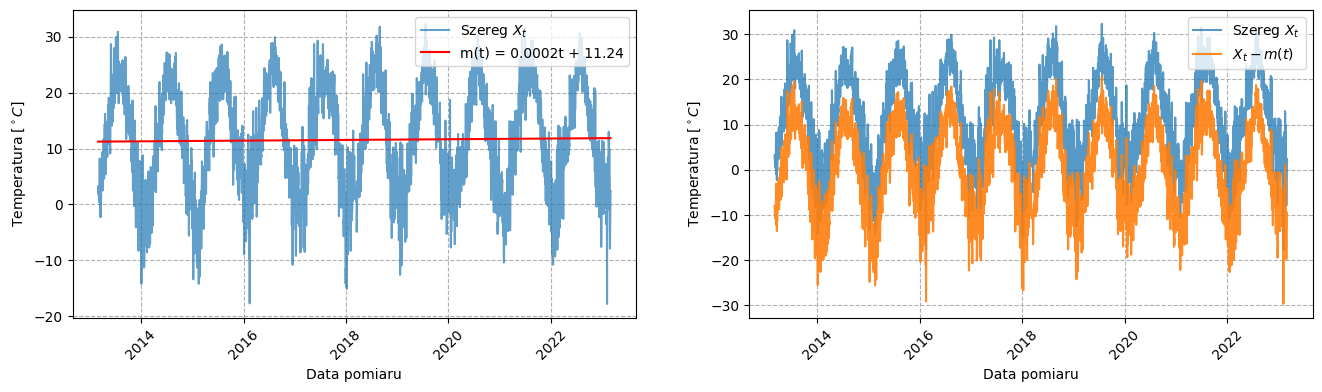

In [125]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(time, Xt, alpha = 0.7, label = 'Szereg $X_t$')
plt.plot(time, mt, color = 'red', label = f'm(t) = {m_fit[0]:.4f}t + {round(m_fit[1],2)}')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.subplot(1,2,2)
plt.plot(time, Xt, alpha = 0.75, label = 'Szereg $X_t$')
plt.plot(time, Xt_without_trend, alpha = 0.9, label = '$X_t - m(t)$')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.savefig('Xt_without_trend.png', bbox_inches='tight')
plt.show()

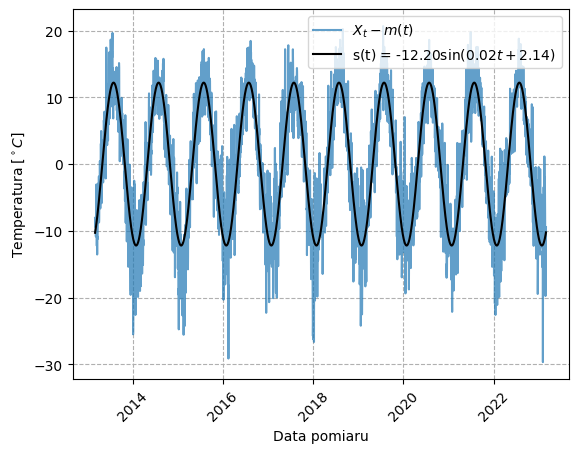

In [126]:
plt.plot(time, Xt_without_trend, alpha = 0.7, label = '$X_t - m(t) $')
plt.plot(time, st, color = 'black', label = f's(t) = {a_fit:.2f}$ \\sin({b_fit:.2f}t+{c_fit:.2f})$')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.savefig('Xt_seasonal.png', bbox_inches='tight')
plt.show()

- Szereg czasowy liniowy $Y_t$

In [127]:
Yt = Xt - mt - st

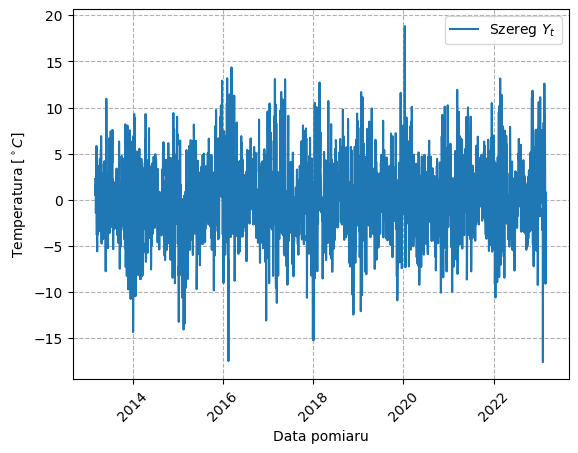

In [128]:
plt.plot(time, Yt, label = 'Szereg $Y_t$')
plt.grid(True, linestyle='--')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend()

plt.savefig('cleanYt.png', bbox_inches='tight')
plt.show()

    2.5. Wykres ACF oraz PACF dla uzyskanego szeregu Yt

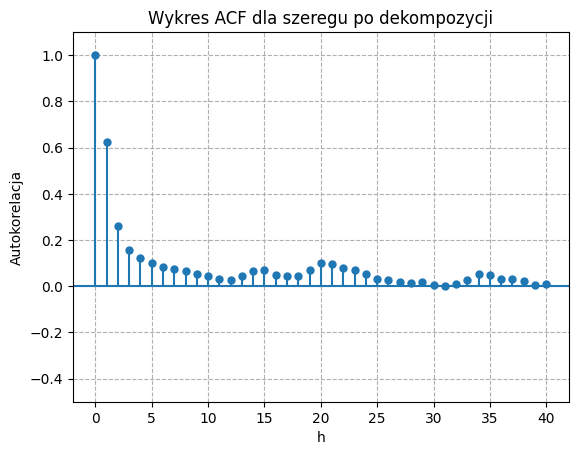

In [129]:
plot_acf(Yt, lags=h, alpha = None)
plt.title("Wykres ACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('ACF_data.png', bbox_inches='tight')
plt.show()

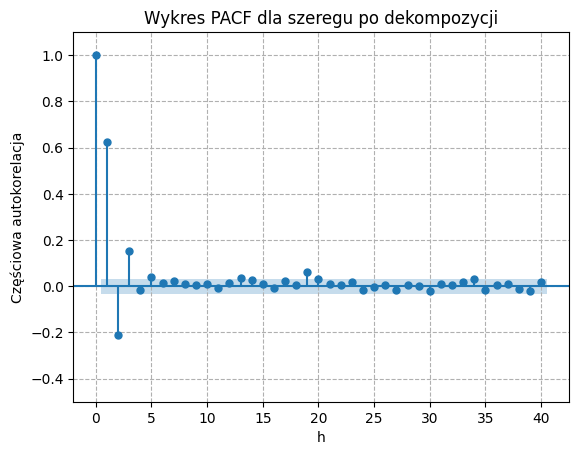

In [130]:
plot_pacf(Yt, lags=h, method='ywm')
plt.title("Wykres PACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_data.png', bbox_inches='tight')
plt.show()


    2.6. (*opcjonalne) Testowanie stacjonarności - po dekompozycji

In [131]:
is_Yt_stationary = adfuller_test(Yt)
is_Yt_stationary

Statystyka testowa = -10.159, p-Value = 0.0 => Stationary. 


## 3. Modelowanie danych przy pomocy ARMA

    3.1. Dobranie rzędu modelu (kryteria informacyjne)

In [132]:
p_values = []
q_values = []
BIC = []
AIC = []
HQIC = []
df = pd.DataFrame()

max_p = 3
max_q = 3

for p in range(0, max_p):
    for q in range(0, max_q):
        
        arima_model = ARIMA(Yt, order=(p, 0, q))
        arima_model_fit = arima_model.fit()
        
        p_values.append(p)
        q_values.append(q)
        AIC.append(arima_model_fit.aic)
        BIC.append(arima_model_fit.bic)
        HQIC.append(arima_model_fit.hqic)

df['p'] = p_values
df['q'] = q_values
df['AIC'] = AIC
df['BIC'] = BIC
df['HQIC'] = HQIC


In [133]:
#posortowanie wartości wg wartości AIC (od najmniejszej)
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
8,2,2,18637.794062,18675.013886,18651.048506
5,1,2,18655.183531,18686.200051,18666.228901
7,2,1,18659.323432,18690.339952,18670.368802
4,1,1,18661.407956,18686.221172,18670.244252
2,0,2,18702.924067,18727.737283,18711.760363


In [134]:
#posortowanie wartości wg wartości BIC (od najmniejszej)
df.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
8,2,2,18637.794062,18675.013886,18651.048506
5,1,2,18655.183531,18686.200051,18666.228901
4,1,1,18661.407956,18686.221172,18670.244252
7,2,1,18659.323432,18690.339952,18670.368802
2,0,2,18702.924067,18727.737283,18711.760363


In [135]:
#posortowanie wartości wg wartości HQIC (od najmniejszej)
df.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
8,2,2,18637.794062,18675.013886,18651.048506
5,1,2,18655.183531,18686.200051,18666.228901
4,1,1,18661.407956,18686.221172,18670.244252
7,2,1,18659.323432,18690.339952,18670.368802
2,0,2,18702.924067,18727.737283,18711.760363


Zatem nasz model $ARMA(p,q) = ARMA(2,2)$

In [136]:
p, q = 2, 2

    3.2. Estymacja parametrów modelu wybraną metodą.

In [137]:
# method = statespace
statespace_model = ARIMA(Yt, order=(p, 0, q)).fit(method='statespace')
statespace_model.params[1:-1]

array([ 1.25330217, -0.28790965, -0.46537367, -0.414144  ])

In [138]:
# method = innovations
innovations_mle_model = ARIMA(Yt, order=(p, 0, q)).fit(method='innovations_mle')
innovations_mle_model.params[1:-1]

array([ 1.25331363, -0.28793006, -0.46538458, -0.41412933])

In [139]:
# method = hannan_rissanen
hannan_rissanen_model= ARIMA(Yt, order=(p, 0, q)).fit(method='hannan_rissanen')
hannan_rissanen_model.params[1:-1]

array([ 1.08493636, -0.22386188, -0.29518272, -0.34362018])

In [140]:
parameter_frame = pd.DataFrame()
parameter_frame["parametry"] = ["phi_1", "phi_2", "theta_1", "theta_2"]
parameter_frame["statespace"] = statespace_model.params[1:-1]
parameter_frame["innovations_mle"] = innovations_mle_model.params[1:-1]
parameter_frame["hannan_rissanen"] = hannan_rissanen_model.params[1:-1]

parameter_frame


,parametry,statespace,innovations_mle,hannan_rissanen
0,phi_1,1.253302,1.253314,1.084936
1,phi_2,-0.287910,-0.287930,-0.223862
2,theta_1,-0.465374,-0.465385,-0.295183
3,theta_2,-0.414144,-0.414129,-0.343620


##  4. Ocena dopasowania modelu

    4.1. Przedziały ufności dla PACF/ACF

In [141]:
fitted_model = ARIMA(Yt, order=(p, 0, q)).fit()
residuals = fitted_model.resid
sigma_2 = np.var(residuals)
paramsARMA= fitted_model.params[1:-1]

In [142]:
# #symulacja Monte Carlo, aby wyznaczyć kwantyle dla modelu ARMA(2,2)
# fitted_model = ARIMA(Yt, order=(p, 0, q)).fit()
# sigma_2 = np.var(fitted_model.resid)

# N = 100
# h = np.arange(41)
# #sigma_2 = 1 #Zakładamy, że z ma wariancję 1
# parameters = fitted_model.params[1:-1]

# upper_quantile_values_acf = np.zeros(len(h))
# lower_quantile_values_acf = np.zeros(len(h))

# for h_value in h:
    
#     acf_values = np.zeros(N)
#     for j in range(N):
#         z = np.random.normal(0, np.sqrt(sigma_2), n)
#         x = np.zeros(n)
#         for i in range(2, len(x)):
#             x[i] = parameters[0]*x[i-1] + parameters[1]*x[i-2] + z[i] + parameters[2]*z[i-1] + parameters[3]*z[i-2]
            
#         autocorrelation = acf(x, nlags=40, fft=True)
#         acf_values[j] = autocorrelation[h_value]
    
#     upper_quantile_values_acf[h_value] = np.quantile(acf_values, 0.95)
#     lower_quantile_values_acf[h_value] = np.quantile(acf_values, 0.05)

In [143]:
def trajectory_ARMA22(params, sigma_2, n):
    Z = np.random.normal(0, np.sqrt(sigma_2), n)
    X = np.zeros(n)
    fi1, fi2, theta1, theta2 = params
    X[0], X[1] = Z[0], Z[1]
    for i in range(2, n):
        X[i] = fi1 * X[i-1] + fi2 * X[i-2] + Z[i] + theta1 * Z[i-1] + theta2 * Z[i-2]
    return X

In [144]:
def conf_interval(params, sigma_2, n, h):
    Xt = trajectory_ARMA22(params=params, sigma_2=sigma_2, n=n)
    
    _, conf_intervals_acf = acf(Xt, nlags=h, alpha=0.05)
    _, conf_intervals_pacf = pacf(Xt, nlags=h, alpha=0.05)

    lower_acf = conf_intervals_acf[:, 0]
    upper_acf = conf_intervals_acf[:, 1]
    lower_pacf = conf_intervals_pacf[:, 0]
    upper_pacf = conf_intervals_pacf[:, 1]
    
    return lower_acf, upper_acf, lower_pacf, upper_pacf

In [145]:
lower_acf, upper_acf, lower_pacf, upper_pacf = conf_interval(paramsARMA, sigma_2, n=5000, h=h)

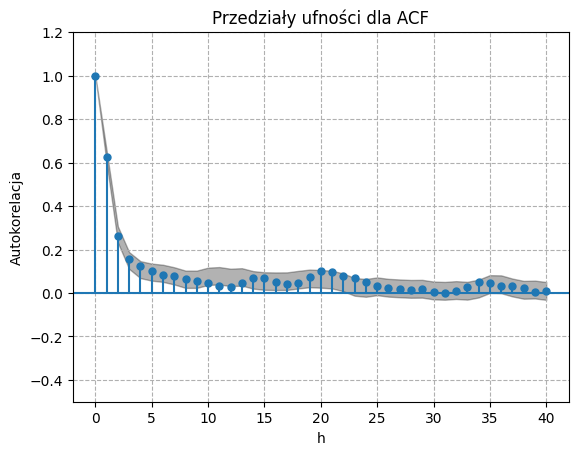

In [197]:
plot_acf(Yt, lags=40, alpha=None) 
plt.fill_between(h_range, lower_acf, upper_acf, color="black", alpha=0.3)
plt.ylim(-0.5, 1.2)  
plt.grid(linestyle="--") 
plt.title("Przedziały ufności dla ACF")
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.savefig('confidence_intervals_acf.png', bbox_inches='tight')

plt.show()

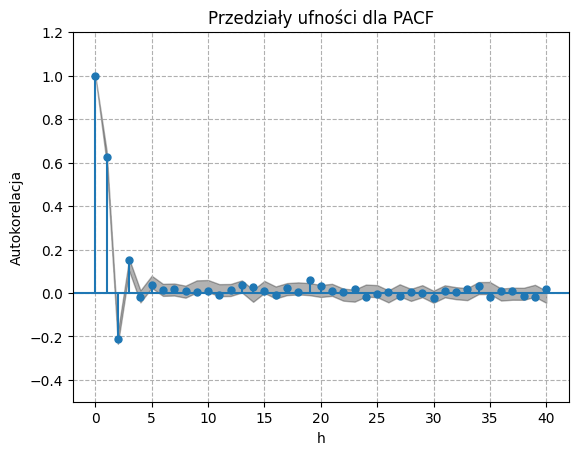

In [196]:
plot_pacf(Yt, lags=40, alpha=None) 
plt.fill_between(h_range, lower_pacf, upper_pacf, color="black", alpha=0.3)
plt.ylim(-0.5, 1.2)  
plt.grid(linestyle="--") 
plt.title("Przedziały ufności dla PACF")
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.savefig('confidence_intervals_pacf.png', bbox_inches='tight')

plt.show()

    4.2 Wykres linii kwantylowych

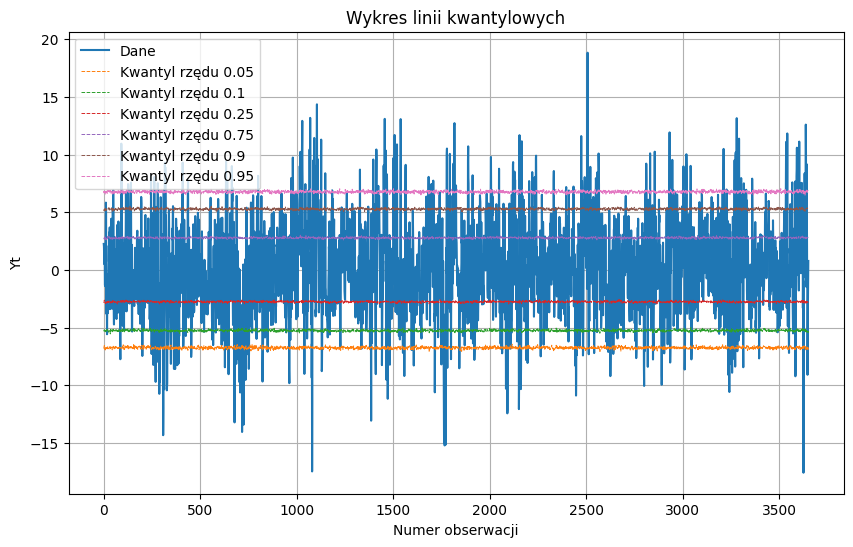

In [148]:
model = fitted_model
n = len(Yt)
m = 10000

B = np.zeros((m, n))

for j in range(m):
    B[j, :] = model.simulate(nsimulations=n)

def quantile(arr, q):
    return np.percentile(arr, q*100, axis=0)

quantiles = [0.05, 0.1, 0.25, 0.75, 0.9, 0.95]

plt.figure(figsize=(10, 6))
plt.plot(Yt, label='Dane')

for q in quantiles:
    plt.plot(quantile(B, q), label = "Kwantyl rzędu " + str(q), linestyle = "--", linewidth=0.7)

plt.title("Wykres linii kwantylowych")
plt.xlabel("Numer obserwacji")
plt.ylabel("Yt")
plt.legend()
plt.grid(True)
plt.savefig('quantile_lines.png', bbox_inches='tight')
plt.show()

## 5. Weryfikacja założeń dotyczących szumu

    5.1. Założenie dot. średniej (wykres wartości resztowych / t test)

a) wykres wartości resztowych

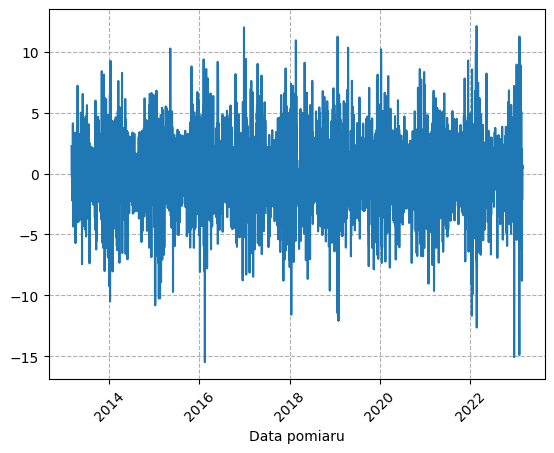

In [149]:
plt.plot(time, residuals)
plt.grid(True, linestyle='--')
plt.xticks(rotation = 45)
plt.xlabel('Data pomiaru')

plt.savefig('residua.png', bbox_inches='tight')
plt.show()

b) t test

$H_0: \mu = 0$

$H_1: \mu \neq 0$

In [150]:
def t_test(Xt, mean_value, confidence_level):
    t_stat, p_value = ttest_1samp(Xt, mean_value)
    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {t_stat}, p-Value = {p_value} < {1- confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {t_stat}, p-Value = {p_value} >= {1- confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [151]:
t_test(residuals , mean_value = 0, confidence_level = 0.95)

Statystyka testowa = -0.012233863917088493, p-Value = 0.9902397005824292 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.


In [152]:
mu_residuals = np.mean(residuals)
mu_residuals

np.float64(-0.0006269266827586221)

    5.2. Założenie dot. wariancji (wykres wartości resztowych / Modified Levene Test / Arch Test)

b) Test Levene’a jednorodności wariancji

$H_0:$ Wszystkie grupy mają tą samą wariancję

$H_1:$ Wariancje są heterogeniczne (niejednorodne)

In [153]:
def levene_test(X, confidence_level):
    n = len(Xt)
    group1 = Xt[:n//2]
    group2 = Xt[n//2:]

    levene_stat, p_value = levene(group1, group2, center = 'mean')
    
    if p_value < 1-confidence_level:
        print(f"Statystyka testowa = {levene_stat}, p-Value = {p_value} < {1- confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {levene_stat}, p-Value = {p_value} >= {1- confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [154]:
levene_test(residuals, confidence_level=0.95)

Statystyka testowa = 1.5965390773592367, p-Value = 0.20647503896086955 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.


c) Test ARCH

In [155]:
def arch_test(Xt, confidence_level):
    arch_stat, p_value, _, _ = het_arch(Xt)
    if p_value < 1-confidence_level:
        print(f"Statystyka testowa = {arch_stat}, p-Value = {p_value} < {1- confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {arch_stat}, p-Value = {p_value} >= {1- confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [156]:
arch_test(residuals, confidence_level=0.95)

Statystyka testowa = 149.74383430144755, p-Value = 4.2083612441482835e-27 < 0.050000000000000044 => Odrzucono hipotezę zerową.


Dostajemy 2 sprzeczne wyniki, zatem przeprowadźmy kolejny test i zobaczmy co wykaże

d) test Brown-Forsythe

In [157]:
def brown_forsythe_test(X, confidence_level):
    n = len(Xt)
    group1 = Xt[:n//3]
    group2 = Xt[n//3:2*n//3]
    group3 = Xt[2*n//3:]

    levene_stat, p_value = levene(group1, group2, group3, center = 'median')
    
    if p_value < 1-confidence_level:
        print(f"Statystyka testowa = {levene_stat}, p-Value = {p_value} < {1- confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {levene_stat}, p-Value = {p_value} >= {1- confidence_level} => Nie można odrzucić hipotezy zerowej.")

e) test Flignera

In [158]:
def fligner_test(X, confidence_level):
    n = len(X)
    group1 = X[:n//3]
    group2 = X[n//3:2*n//3]
    group3 = X[2*n//3:]

    fligner_stat, p_value = fligner(group1, group2, group3)

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {fligner_stat}, p-Value = {p_value} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {fligner_stat}, p-Value = {p_value} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [159]:
fligner_test(residuals, 0.95)

Statystyka testowa = 0.5553579968038815, p-Value = 0.7575399540251213 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.


f) F-test

In [188]:
from scipy.stats import f_oneway

def hartley_test(Xt, confidence_level):
    n = len(Xt)
    group1 = Xt[:n//2]
    group2 = Xt[n//2:]

    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=1)
    H = max(var1, var2) / min(var1, var2)

    f_stat, p_value = f_oneway(group1, group2)

    # Interpretacja wyniku
    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa H = {H}, p-Value = {p_value} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa H = {H}, p-Value = {p_value} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.", {H})



In [191]:
hartley_test(residuals, 0.95)

Statystyka testowa H = 1.0443276928416252, p-Value = 0.16213903472075744 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej. {np.float64(1.0443276928416252)}


    5.3. Założenie dot. niezależności (wykres ACF/PACF dla wartości resztowych / test Ljunga-Boxa)

a) Wykres ACF/PACF dla wartości resztowych

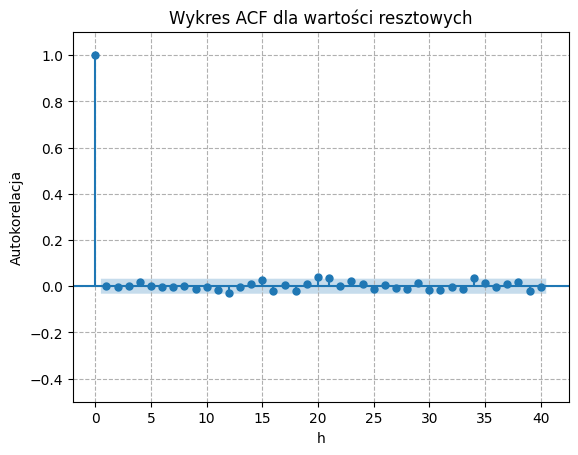

In [160]:
plot_acf(residuals, lags=h)
plt.title("Wykres ACF dla wartości resztowych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('ACF_residua.png', bbox_inches='tight')
plt.show()

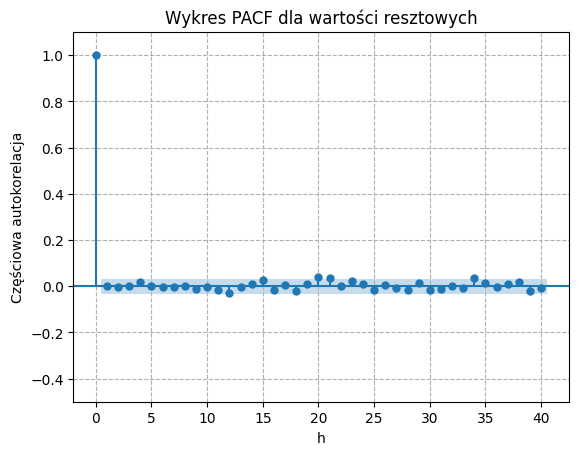

In [161]:
plot_pacf(residuals, lags=h, method='ywm')
plt.title("Wykres PACF dla wartości resztowych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_residua.png', bbox_inches='tight')
plt.show()

b) Test Ljunga-Boxa

$H_0:$ dane są nieskorelowane

$H_1:$ dane są skorelowane

In [162]:
def LB_test(X, h, confidence_level):
    LB_result = acorr_ljungbox(X, lags=h, return_df=True)  #
    LB_stat = LB_result['lb_stat'].iloc[0]
    p_value = LB_result['lb_pvalue'].iloc[0]

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {LB_stat:.4f}, p-Value = {p_value:.4f} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {LB_stat:.4f}, p-Value = {p_value:.4f} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [163]:
LB_test(residuals, h = h, confidence_level =  0.95)

Statystyka testowa = 0.0002, p-Value = 0.9900 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.


    5.4. Założenie dot. normalności rozkładu (dystrybuanta / gęstość / wykres kwantylowy / testy na normalność)

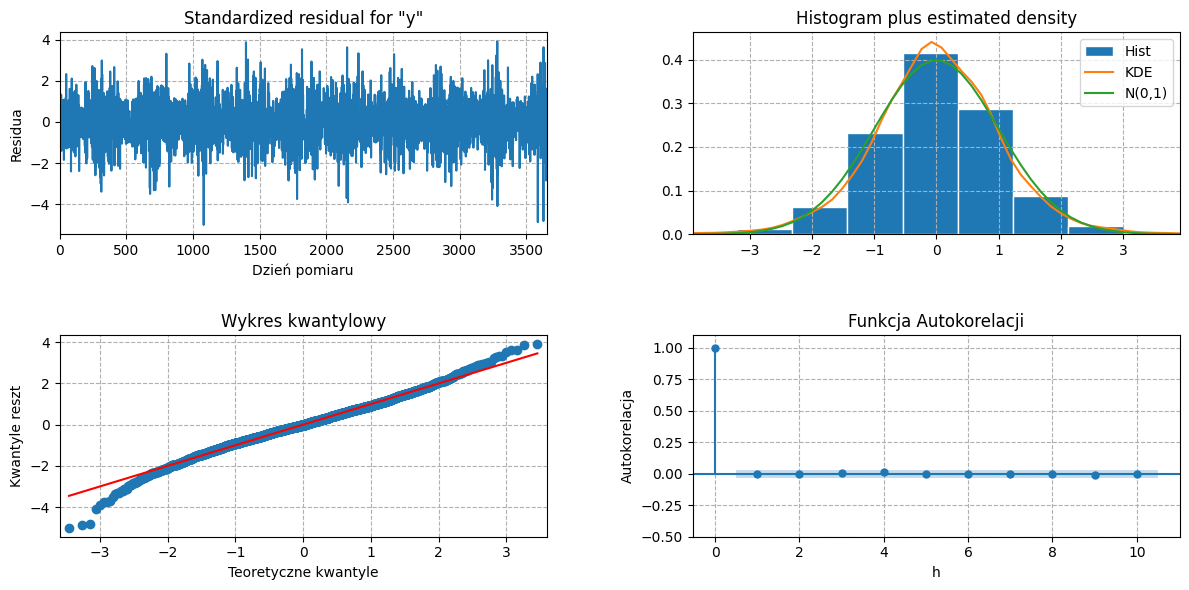

In [164]:
fig = fitted_model.plot_diagnostics(0, figsize=(12, 6))
axes = fig.get_axes()
for ax in axes:
    ax.grid(True, linestyle='--')

#wykres 1
axes[0].set_ylabel('Residua')
axes[0].set_xlabel('Dzień pomiaru')

#wykres 2

#wykres 3
axes[2].set_ylabel('Kwantyle reszt')
axes[2].set_xlabel('Teoretyczne kwantyle')
axes[2].set_title('Wykres kwantylowy')

#wykres 4
axes[3].set_ylim(-0.5, 1.1)
axes[3].set_ylabel('Autokorelacja')
axes[3].set_xlabel('h')
axes[3].set_title('Funkcja Autokorelacji')


plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


In [165]:
xs = np.linspace(np.min(residuals), np.max(residuals), 1000)
f_normal = norm.pdf(xs, mu_residuals, np.sqrt(sigma_2))
F_normal = norm.cdf(xs, mu_residuals, np.sqrt(sigma_2))

- dystrybuanta

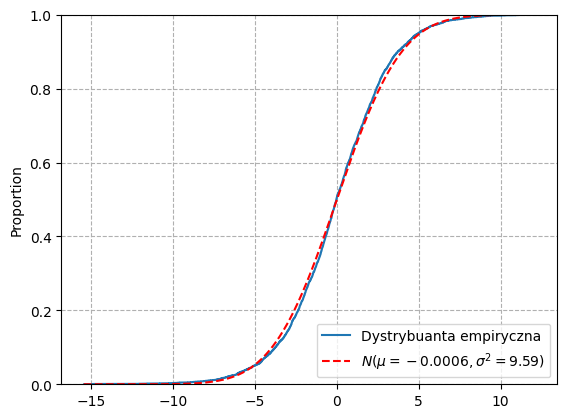

In [199]:
sns.ecdfplot(residuals, label = "Dystrybuanta empiryczna")
plt.plot(xs, F_normal, 'r--', label = f'$N(\\mu = {mu_residuals:.4f}, \\sigma^2 = {sigma_2:.2f})$')
plt.grid(True, linestyle='--')
plt.legend(loc='lower right')

plt.savefig('F_residua.png', bbox_inches='tight')
plt.show()

- gęstość

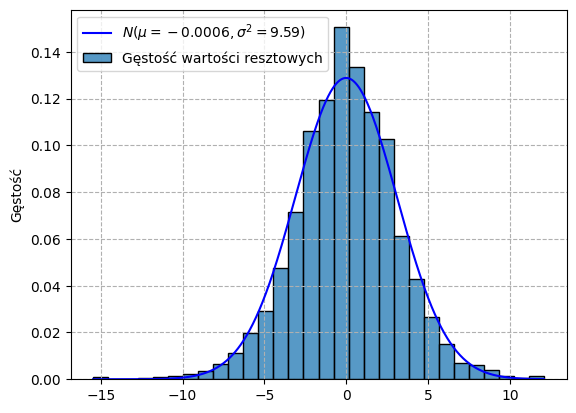

In [195]:
sns.histplot(residuals, bins = 30, stat="density", label = 'Gęstość wartości resztowych')
plt.plot(xs, f_normal, 'b', label = f'$N(\\mu = {mu_residuals:.4f}, \\sigma^2 = {sigma_2:.2f})$')
plt.grid(True, linestyle='--')
plt.ylabel('Gęstość')
plt.legend()

plt.savefig('density_residua.png', bbox_inches='tight')
plt.show()

- Wykres kwantylowy

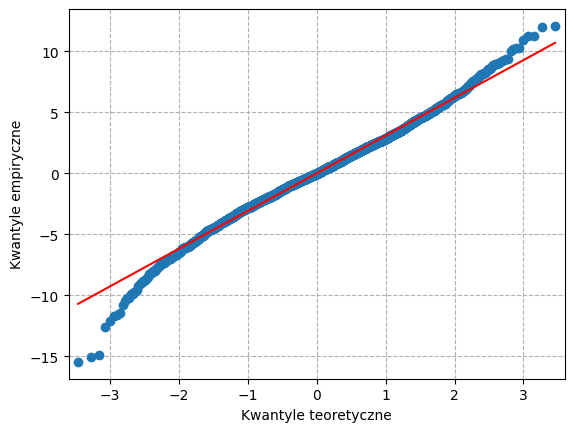

In [194]:
# QQ plot
sm.qqplot(residuals, line="s")
plt.xlabel('Kwantyle teoretyczne')
plt.ylabel('Kwantyle empiryczne')
plt.grid(True, linestyle = '--')

plt.savefig('QQ_residua.png', bbox_inches='tight')
plt.show()

- Testy na normalność

W każdym teście testujemy 2 następujące hipotezy:

$H_0$: Próba pochodzi z populacji o rozkładzie normalnym

$H_1$: Próba nie pochodzi z populacji o rozkładzie normalnym

a) Test Shapiro-Wilka

In [169]:
def shapiro_test(X, confidence_level):
    shapiro_stat, p_value = shapiro(X)

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {shapiro_stat:.4f}, p-Value = {p_value:.4f} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {shapiro_stat:.4f}, p-Value = {p_value:.4f} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [170]:
shapiro_test(residuals, confidence_level=0.95)

Statystyka testowa = 0.9922, p-Value = 0.0000 < 0.050000000000000044 => Odrzucono hipotezę zerową.


b) Test Jarque-Bera - oparty na miarach skośności i kurtozy rozkładu badanej zmiennej. 

In [171]:
def JB_test(X, confidence_level):
    JB_stat, p_value = jarque_bera(X)

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {JB_stat:.4f}, p-Value = {p_value:.4f} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {JB_stat:.4f}, p-Value = {p_value:.4f} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [172]:
JB_test(residuals, confidence_level=0.95)

Statystyka testowa = 191.6356, p-Value = 0.0000 < 0.050000000000000044 => Odrzucono hipotezę zerową.


Jak się okazuje nasz szum nie spełnia założeń dotyczących normalności. W tym przypadku sprawdźmy czy uda nam się dopasować inny rozkład.

Sprawdźmy zgodność dla rozkładu t-Studenta

    5.5 Czy szum ma rozkład t-Studenta?

In [173]:
xs = np.linspace(np.min(residuals), np.max(residuals), 1000)
df_residuals = len(residuals) - p - q

df_student, mu_student, std_student = scipy.stats.t.fit(residuals)
f_student = scipy.stats.t.pdf(xs, df_student, mu_student, std_student)
F_student = scipy.stats.t.cdf(xs, df_student, mu_student, std_student)

In [204]:
df_student = int(df_student)

In [174]:
mu_residuals

np.float64(-0.0006269266827586221)

In [175]:
mu_student

np.float64(0.013795719012644325)

- dystrybuanta

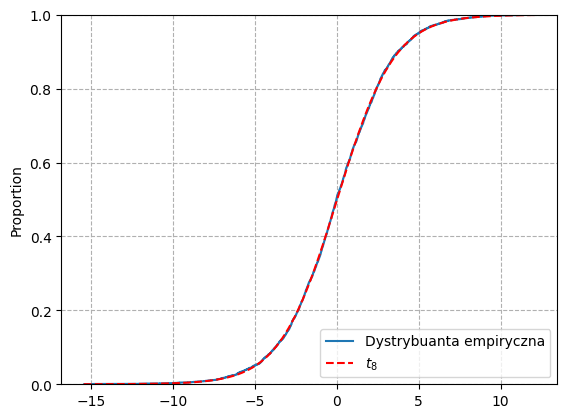

In [207]:
sns.ecdfplot(residuals, label = "Dystrybuanta empiryczna")
plt.plot(xs, F_student, 'r--', label=f'$t_{{{df_student}}}$')
plt.grid(True, linestyle='--')
plt.legend(loc='lower right')

plt.savefig('F_student.png', bbox_inches='tight')
plt.show()

- gęstość

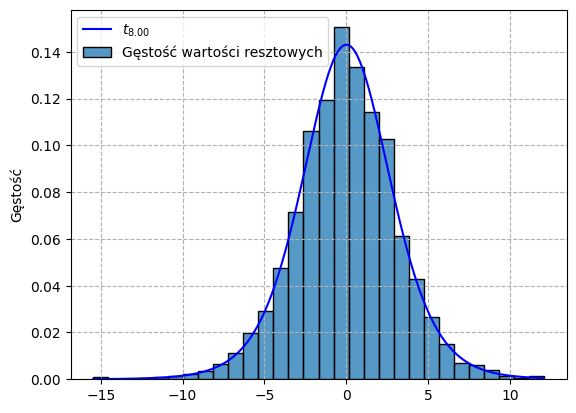

In [ ]:
sns.histplot(residuals, bins = 30, stat="density", label = 'Gęstość wartości resztowych')
plt.plot(xs, f_student, 'b', label = f'$t_{{{df_student}}}$')
plt.grid(True, linestyle='--')
plt.ylabel('Gęstość')
plt.legend()

plt.savefig('density_student.png', bbox_inches='tight')
plt.show()

- wykres kwantylowy

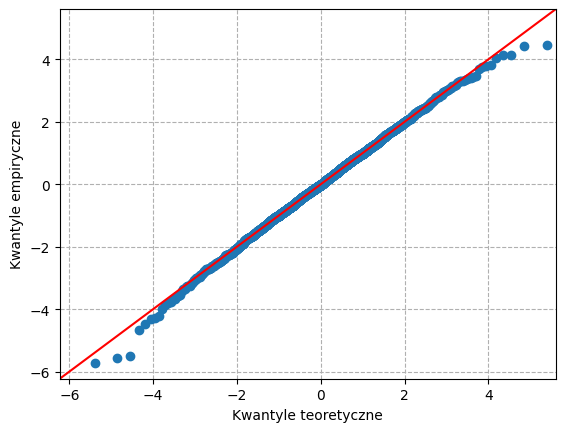

In [192]:
# QQ plot
sm.qqplot(residuals, dist = scipy.stats.t, fit = True,  line='45')
plt.grid(True, linestyle = '--')
plt.xlabel('Kwantyle teoretyczne')
plt.ylabel('Kwantyle empiryczne')

plt.savefig('QQ_student.png', bbox_inches='tight')
plt.show()

- testy na t-Studenta

a) test Kołmogorowa - Smirnowa

In [179]:
def KS_test(X, dist_name, dist_args, confidence_level):
    KS_stat, p_value = kstest(X, dist_name, args=dist_args)

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {KS_stat:.4f}, p-Value = {p_value:.4f} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {KS_stat:.4f}, p-Value = {p_value:.4f} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [205]:
KS_test(residuals, 't', (df_student,mu_student,std_student), 0.95)

Statystyka testowa = 0.0104, p-Value = 0.8190 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.


b) test Cramera von Misesa

In [181]:
def CvonM_test(X, dist_name, dist_args, confidence_level):
    result = cramervonmises(X, dist_name, args=dist_args)
    
    CM_stat = result.statistic
    p_value = result.pvalue

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {CM_stat:.4f}, p-Value = {p_value:.4f} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {CM_stat:.4f}, p-Value = {p_value:.4f} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")


In [182]:
CvonM_test(residuals, 't', (df_student,mu_student,std_student), 0.95)


Statystyka testowa = 0.0410, p-Value = 0.9277 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.
